In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lxml import html
import requests
from bs4 import BeautifulSoup
import pandas_datareader.data as web
import os
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import datetime as datetime

In [2]:
start=pd.to_datetime('1-1-2010')
end=pd.to_datetime(datetime.date.today())
stock=web.DataReader('MMM', 'google', start, end)

In [3]:
stock['Change'] = (stock['Close'] - stock['Open']) / stock['Open']
stock['Fluct'] = ((stock['High'] - stock['Low']) / stock['Open']) - stock['Change']
stock['Vol_Fluct'] = (stock['Volume'] - np.mean(stock['Volume'])) / np.mean(stock['Volume'])

In [16]:
expected_return=[]
lose_occurrences=[]
win_occurrences=[]
lose_counter=0
win_counter=0
buy_date=14 #default 14
sell_date=21 #default 21 or 22 (using 21)
measured_value='Vol_Fluct'
i=0
while i<(len(stock['Close'])-30):
    if (stock['Close'][i + 4] > stock['Close'][i]) and (stock['Close'][i + 5] < stock['Close'][i + 1]) \
            and (stock['Close'][i + 13] < stock['Close'][i + 5]):
        if (stock['Close'][i + sell_date] - stock['Close'][i + buy_date]) < 0:
            lose_occurrences.insert(lose_counter, stock[measured_value][i:i + 25])
            lose_counter += 1
        if (stock['Close'][i + sell_date] - stock['Close'][i + buy_date]) > 0:
            win_occurrences.insert(win_counter, stock[measured_value][i:i + 25])
            win_counter += 1
        i+=20
        expected_return.append(stock['Close'][i + sell_date] - stock['Close'][i + buy_date])
    else:
        i+=1

0.855333333333
45


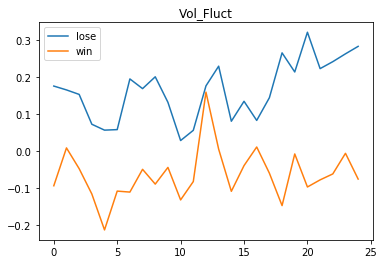

In [18]:
print(np.mean(expected_return))
print(len(expected_return))
plt.plot(np.mean(lose_occurrences,axis=0), label='lose')
plt.plot(np.mean(win_occurrences, axis=0), label='win')
plt.title(measured_value)
plt.legend()
plt.show()

In [19]:
ten_day_average = list(np.zeros(50))
ten_day_average_volume = list(np.zeros(50))
ten_day_std = list(np.zeros(50))
ten_day_std_volume = list(np.zeros(50))
ten_day_average_fluct = list(np.zeros(50))
forty_day_average = list(np.zeros(50))
forty_day_average_volume = list(np.zeros(50))
forty_day_std = list(np.zeros(50))
forty_day_std_volume = list(np.zeros(50))
forty_day_average_fluct = list(np.zeros(50))
for j in range(50, len(stock['Change'])):
    ten_day_average.append(np.mean(stock['Close'][j - 10:j]))
    ten_day_average_fluct.append(np.mean(stock['Fluct'][j - 10:j]))
    forty_day_average.append(np.mean(stock['Close'][j - 40:j]))
    forty_day_average_fluct.append(np.mean(stock['Fluct'][j - 40:j]))
    ten_day_average_volume.append(np.mean(stock['Volume'][j - 10:j]))
    forty_day_average_volume.append(np.mean(stock['Volume'][j - 40:j]))

stock['10_day_av'] = ten_day_average
stock['40_day_av'] = forty_day_average
stock['10_day_fluct_av'] = ten_day_average_fluct
stock['40_day_fluct_av'] = forty_day_average_fluct
stock['10_day_av_vol'] = ten_day_average_volume
stock['40_day_av_vol'] = forty_day_average_volume

for j in range(50, len(stock['Change'])):
    ten_day_std.append(np.std(stock['Close'][j-10:j])/stock['10_day_av'][j])
    forty_day_std.append(np.std(stock['Close'][j-40:j])/stock['40_day_av'][j])
    ten_day_std_volume.append(np.std(stock['Volume'][j - 10:j]) / stock['10_day_av_vol'][j])
    forty_day_std_volume.append(np.std(stock['Volume'][j - 40:j]) / stock['40_day_av_vol'][j])

stock['10_day_std'] = ten_day_std
stock['40_day_std'] = forty_day_std
stock['10_day_std_vol'] = ten_day_std_volume
stock['40_day_std_vol'] = forty_day_std_volume
stock['10_day_change'] = (stock['Close']-stock['10_day_av'])/stock['10_day_av']
stock['40_day_change'] = (stock['Close']-stock['40_day_av'])/stock['40_day_av']
stock['10_day_change_vol'] = (stock['Volume'] - stock['10_day_av_vol']) / stock['10_day_av_vol']
stock['40_day_change_vol'] = (stock['Volume'] - stock['40_day_av_vol']) / stock['40_day_av_vol']

In [26]:
stock_features=[]
i = 50
while i < (len(stock['Close']) - 50):
    # this if statement contains the reverse td_sequential, the correct one is below.
    # if (stock['Close'][i + 4] < stock['Close'][i]) and (stock['Close'][i + 5] > stock['Close'][i + 1]) \
    # and (stock['Close'][i + 13] < stock['Close'][i + 5]):
    add_values = []
    if (stock['Close'][i + 4] > stock['Close'][i]) and (stock['Close'][i + 5] < stock['Close'][i + 1]) \
            and (stock['Close'][i + 13] < stock['Close'][i + 5]):
        day_to_learn = i
        add_values.append(stock['10_day_std'][day_to_learn])
        add_values.append(stock['40_day_std'][day_to_learn])
        add_values.append(stock['10_day_std_vol'][day_to_learn])
        add_values.append(stock['40_day_std_vol'][day_to_learn])
        add_values.append(stock['10_day_change'][day_to_learn])
        add_values.append(stock['40_day_change'][day_to_learn])
        add_values.append(stock['10_day_change_vol'][day_to_learn])
        add_values.append(stock['40_day_change_vol'][day_to_learn])
        add_values.append(stock['10_day_fluct_av'][day_to_learn])
        add_values.append(stock['40_day_fluct_av'][day_to_learn])
        add_values.append(stock['Close'][i + sell_date] - stock['Close'][i + buy_date])
        # if (stock['Close'][i + sell_date] - stock['Close'][i + buy_date]) < 0:
        # add_values.append(0)
        # if (stock['Close'][i + sell_date] - stock['Close'][i + buy_date]) > 0:
        # add_values.append(1)
        i += 20
        stock_features.append(add_values)
    else:
        i += 1

In [27]:
stock_features=np.array(stock_features)
stock_features[:, 10]=stock_features[:, 10]>0
model=RandomForestClassifier(100, oob_score=True, n_jobs=-1)
train, test=sklearn.model_selection.train_test_split(stock_features, test_size=.3, \
                                                     stratify=stock_features[:, 10])

fit=model.fit(train[:,0:10], train[:, 10])
pred=fit.predict(train[:,0:10])
#print('Random Forest Training Accuracy: ' + str(np.sum(np.sign(pred)==np.sign(train[:,10]))/len(pred)))
print(np.sum(pred == train[:, 10]) / len(pred))
pred=fit.predict(test[:,0:10])
#print('Random Forest Test Accuracy: ' + str(np.sum(np.sign(pred)==np.sign(test[:,10]))/len(pred)))
print(np.sum(pred == test[:, 10]) / len(pred))

1.0
0.692307692308
